### Color Histogram

In [1]:
# import the necessary packages
from matplotlib import pyplot as plt
import numpy as np
import argparse
import cv2
import csv
 
# construct the argument parser and parse the arguments
args = {'image': 'queryImages/sample_1.jpg'}
 
# load the image and show it
image = cv2.imread(args["image"])
cv2.imshow("image", image)

(0, 256)

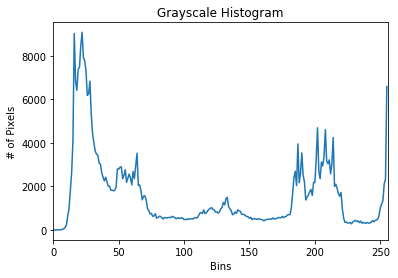

In [2]:
# convert the image to grayscale and create a histogram
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imshow("gray", gray)
hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])

flattened feature vector size: 768


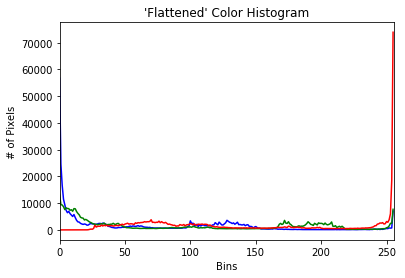

In [3]:
# grab the image channels, initialize the tuple of colors,
# the figure and the flattened feature vector
chans = cv2.split(image)
colors = ("b", "g", "r")
plt.figure()
plt.title("'Flattened' Color Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
features = []
 
# loop over the image channels
for (chan, color) in zip(chans, colors):
# create a histogram for the current channel and
# concatenate the resulting histograms for each
# channel
    hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
    features.extend(hist)
 
 # plot the histogram
    plt.plot(hist, color = color)
    plt.xlim([0, 256])
 
# here we are simply showing the dimensionality of the
# flattened color histogram 256 bins for each channel
# x 3 channels = 768 total values -- in practice, we would
# normally not use 256 bins for each channel, a choice
# between 32-96 bins are normally used, but this tends
# to be application dependent
print ("flattened feature vector size: %d" % (np.array(features).flatten().shape))

2D histogram shape: (32, 32), with 1024 values


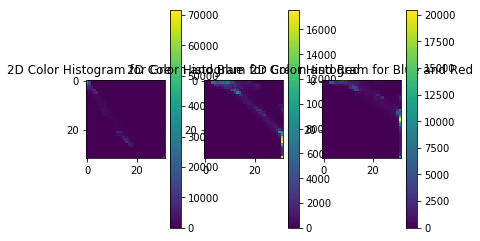

In [ ]:
# let's move on to 2D histograms -- I am reducing the
# number of bins in the histogram from 256 to 32 so we
# can better visualize the results
fig = plt.figure()
 
# plot a 2D color histogram for green and blue
ax = fig.add_subplot(131)
hist = cv2.calcHist([chans[1], chans[0]], [0, 1], None, [32, 32], [0, 256, 0, 256])
p = ax.imshow(hist, interpolation = "nearest")
ax.set_title("2D Color Histogram for Green and Blue")
plt.colorbar(p)
 
# plot a 2D color histogram for green and red
ax = fig.add_subplot(132)
hist = cv2.calcHist([chans[1], chans[2]], [0, 1], None, [32, 32], [0, 256, 0, 256])
p = ax.imshow(hist, interpolation = "nearest")
ax.set_title("2D Color Histogram for Green and Red")
plt.colorbar(p)
 
# plot a 2D color histogram for blue and red
ax = fig.add_subplot(133)
hist = cv2.calcHist([chans[0], chans[2]], [0, 1], None, [32, 32], [0, 256, 0, 256])
p = ax.imshow(hist, interpolation = "nearest")
ax.set_title("2D Color Histogram for Blue and Red")
plt.colorbar(p)
 
# finally, let's examine the dimensionality of one of
# the 2D histograms
print ("2D histogram shape: %s, with %d values" % (
hist.shape, hist.flatten().shape[0]))

In [ ]:
# our 2D histogram could only take into account 2 out
# of the 3 channels in the image so now let's build a
# 3D color histogram (utilizing all channels) with 8 bins
# in each direction -- we can't plot the 3D histogram, but
# the theory is exactly like that of a 2D histogram, so
# we'll just show the shape of the histogram
hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
print ("3D histogram shape: %s, with %d values" % (hist.shape, hist.flatten().shape[0]))

3D histogram shape: (8, 8, 8), with 512 values


In [ ]:
# import the necessary packages
import numpy as np
import cv2
import imutils
 
class ColorDescriptor:
    def __init__(self, bins):
# store the number of bins for the 3D histogram
        self.bins = bins
 
    def describe(self, image):
# convert the image to the HSV color space and initialize
# the features used to quantify the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        features = []
 
 # grab the dimensions and compute the center of the image
        (h, w) = image.shape[:2]
        (cX, cY) = (int(w * 0.5), int(h * 0.5))
# divide the image into four rectangles/segments (top-left,
# top-right, bottom-right, bottom-left)
        segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h), (0, cX, cY, h)]
 
 # construct an elliptical mask representing the center of the
# image
        (axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
        ellipMask = np.zeros(image.shape[:2], dtype = "uint8")
        cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)
 
 # loop over the segments
        for (startX, endX, startY, endY) in segments:
# construct a mask for each corner of the image, subtracting
# the elliptical center from it
            cornerMask = np.zeros(image.shape[:2], dtype = "uint8")
            cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
            cornerMask = cv2.subtract(cornerMask, ellipMask)
 
 # extract a color histogram from the image, then update the
# feature vector
            hist = self.histogram(image, cornerMask)
            features.extend(hist)
 
 # extract a color histogram from the elliptical region and
# update the feature vector
        hist = self.histogram(image, ellipMask)
        features.extend(hist)
 
 # return the feature vector
        return features
    def histogram(self, image, mask):
# extract a 3D color histogram from the masked region of the
# image, using the supplied number of bins per channel
        hist = cv2.calcHist([image], [0, 1, 2], mask, self.bins, [0, 180, 0, 256, 0, 256])
 
 # normalize the histogram if we are using OpenCV 2.4
        if imutils.is_cv2():
            hist = cv2.normalize(hist).flatten()
 
 # otherwise handle for OpenCV 3+
        else:
            hist = cv2.normalize(hist, hist).flatten()
 
 # return the histogram
        return hist

## Reference Image Features

In [ ]:
# import the necessary packages
import glob
import cv2

# construct the argument
args = {
"dataset": "referenceImages/",
"index": "index.csv"
}

# initialize the color descriptor
cd = ColorDescriptor((8, 12, 3))

# open the output index file for writing
output = open(args["index"], "w")

# use glob to grab the image paths and loop over them
for imagePath in glob.glob(args["dataset"] + "/*.png"):
# extract the image ID (i.e. the unique filename) from the image
# path and load the image itself
    imageID = imagePath[imagePath.rfind("/") + 1:]
    image = cv2.imread(imagePath)

# describe the image
    features = cd.describe(image)

# write the features to file
    features = [str(f) for f in features]
    output.write("%s,%s\n" % (imageID, ",".join(features)))

# close the index file
output.close()




## Find closest neighbor with chi-squared

In [ ]:
# import the necessary packages
import numpy as np

class Searcher:
    def __init__(self, indexPath):
# store our index path
        self.indexPath = indexPath
 
    def search(self, queryFeatures, limit = 10):
# initialize our dictionary of results
        results = {}
    # open the index file for reading
        with open(self.indexPath) as f:
# initialize the CSV reader
            reader = csv.reader(f)
 
 # loop over the rows in the index
            for row in reader:
# parse out the image ID and features, then compute the
# chi-squared distance between the features in our index
# and our query features
                features = [float(x) for x in row[1:]]
                d = self.chi2_distance(features, queryFeatures)
 
 # now that we have the distance between the two feature
# vectors, we can udpate the results dictionary -- the
# key is the current image ID in the index and the
# value is the distance we just computed, representing
# how 'similar' the image in the index is to our query
                results[row[0]] = d
 
 # close the reader
            f.close()
 
 # sort our results, so that the smaller distances (i.e. the
# more relevant images are at the front of the list)
        results = sorted([(v, k) for (k, v) in results.items()])
 
 # return our (limited) results
        return results[:limit]
    def chi2_distance(self, histA, histB, eps = 1e-10):
# compute the chi-squared distance
        d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
            for (a, b) in zip(histA, histB)])
 
 # return the chi-squared distance
        return d

In [ ]:
# import the necessary packages
# from pyimagesearch.colordescriptor import ColorDescriptor
# from pyimagesearch.searcher import Searcher
# import argparse
import cv2
import csv
 
# construct the argument
args = {'index': 'index.csv', 
       'query': 'queryImages/sample_4.jpg',
       'result': 'referenceImages/'}
 
# initialize the image descriptor
cd = ColorDescriptor((8, 12, 3))

# load the query image and describe it
query = cv2.imread(args["query"])
features = cd.describe(query)
 
# perform the search
searcher = Searcher(args["index"])
results = searcher.search(features)
 
# display the query
cv2.imshow("Query", query)
 
# loop over the results
for (score, resultID) in results:
# load the result image and display it
    result = cv2.imread(args["result"] + "/" + resultID)
    cv2.imshow("Result", result)
    cv2.waitKey(0)